In [4]:
import pandas as pd
from tqdm import tqdm
import datetime
from dateutil.relativedelta import relativedelta

water_level_tg_dir = r"Edited_Data\Tagoloan\tag.csv"
rg0_tg_dir = r"Edited_Data\Tagoloan\rg0.csv"
rg1_level_tg_dir = r"Edited_Data\Tagoloan\rg1.csv"

water_level_cag_dir = r"Edited_Data\Cagayan\cag.csv"
rg0_cag_dir = r"Edited_Data\Cagayan\rg0.csv"
rg1_level_cag_dir = r"Edited_Data\Cagayan\rg1.csv"

In [5]:
water_level_tg = pd.read_csv(water_level_tg_dir, index_col=0)
rg0_tg = pd.read_csv(rg0_tg_dir, index_col=0)
rg1_tg = pd.read_csv(rg1_level_tg_dir, index_col=0)

water_level_cag = pd.read_csv(water_level_cag_dir, index_col=0)
rg0_cag = pd.read_csv(rg0_cag_dir, index_col=0)
rg1_cag = pd.read_csv(rg1_level_cag_dir, index_col=0)

In [6]:
all_df = [water_level_tg, rg0_tg, rg1_tg, water_level_cag, rg0_cag, rg1_cag]
def date_time_converter(df):
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df['Timestamp'] = df['Timestamp'].apply(lambda x: x.strftime(format="%Y-%m-%d %H:00:00"))
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], format="%Y-%m-%d %H:00:00")
    return df


converted_df = []
for df in tqdm(all_df):
    # df['Timestamp'] = df['Timestamp'].apply(lambda x: pd.to_datetime(x).strftime(format="%Y-%m-%d %H:00:00"))
    df = date_time_converter(df)
    df.drop_duplicates(keep='first', inplace=True)
    df = df.loc[:,['Timestamp', 'Sensor Value']]
    converted_df.append(df)
df_names = ["Tagoloan Water Level Data Availability",
            "Tagoloan Rain Gauge 1 Data Availability",
            "Tagoloan Rain Gauge 2 Data Availability",
            "Cagayan Water Level Data Availability",
            "Cagayan Rain Gauge 1 Data Availability",
            "Cagayan Rain Gauge 2 Data Availability"]

#Create a dictionary
df_dict = {}
for name,df in zip(df_names, converted_df):
    df_dict[name] = df

100%|██████████| 6/6 [00:19<00:00,  3.25s/it]


In [7]:
def make_base_time(cag):
    cag = cag.sort_values(by="Timestamp", ignore_index=True).reset_index(drop=True)
    start_date = cag.loc[0,"Timestamp"]
    end_date = cag.loc[len(cag)-1,"Timestamp"]
    base_time = pd.DataFrame({'Timestamp':pd.date_range(start=start_date, end=end_date, freq="h")})
    return base_time


def time_sorter(df):
    base_time = make_base_time(df)
    base_time = date_time_converter(base_time)  #Format must be similar to the dfs
    merged_df = pd.merge(base_time, df, how='outer', on='Timestamp')
    merged_df = merged_df.set_index('Timestamp')
    return merged_df

final_df = []
for idx, df in tqdm(enumerate(converted_df)):
    df = time_sorter(df)
    df = df.rename(columns = {'Sensor Value':df_names[idx]})
    final_df.append(df)

complete_df = pd.concat(final_df)
complete_df.sort_index(inplace=True)
#merge all dfs
# complete_df = final_df[0]
# complete_df = complete_df.rename({'Sensor Value': df_names[0]})
# for idx, df in enumerate(final_df[1:]):
#     complete_df = p(complete_df,df, how='outer', )
complete_df = complete_df.reset_index()
complete_df = complete_df.groupby(by='Timestamp',).mean()


6it [00:00,  6.28it/s]


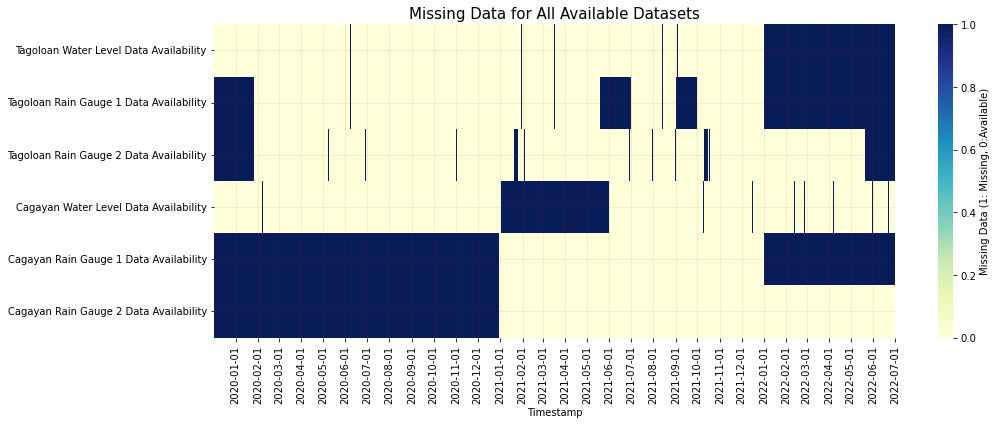

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt, mpld3

def plot_missing(complete_df):
    fig, ax = plt.subplots(figsize=(15,6))
    ax = sns.heatmap(
        data = complete_df.isna().transpose(),
        cmap="YlGnBu",
        cbar_kws={'label': 'Missing Data (1: Missing, 0:Available)'}
    )

    date_indices = [i for i,x in enumerate(list(complete_df.index)) if i%10000==0]
    dates = [(str(x)) for i,x in enumerate(list(complete_df.index)) if i%10000==0]
    ax.set_xticks(date_indices)
    ax.set_xticklabels(dates, rotation='vertical')

    start_date = complete_df.index[0]
    end_date = complete_df.index[-1]
    month_range = pd.date_range(start_date, end_date, freq='m') + pd.DateOffset(days=1)

    # get the indices of the dates that match with month range
    indices = [i for i, x in enumerate(complete_df.index) if x in month_range]
    dates = [str(x.date()) for i, x in enumerate(complete_df.index) if x in month_range]

    # Set tick locations and labels
    ax.set_xticks(indices)
    ax.set_xticklabels(dates)

    #Set figure properties
    ax.set_title("Missing Data for All Available Datasets", fontdict={'fontsize':15})
    ax.grid(color='r', alpha=0.1)
    fig.tight_layout()
    return fig,ax

fig, ax = plot_missing(complete_df)

fig.savefig('Missing Data.jpeg', transparent=True)

# Select Time Range

Date start is 2021-09-01 00:00:00 and End Date is 2022-01-01 00:00:00


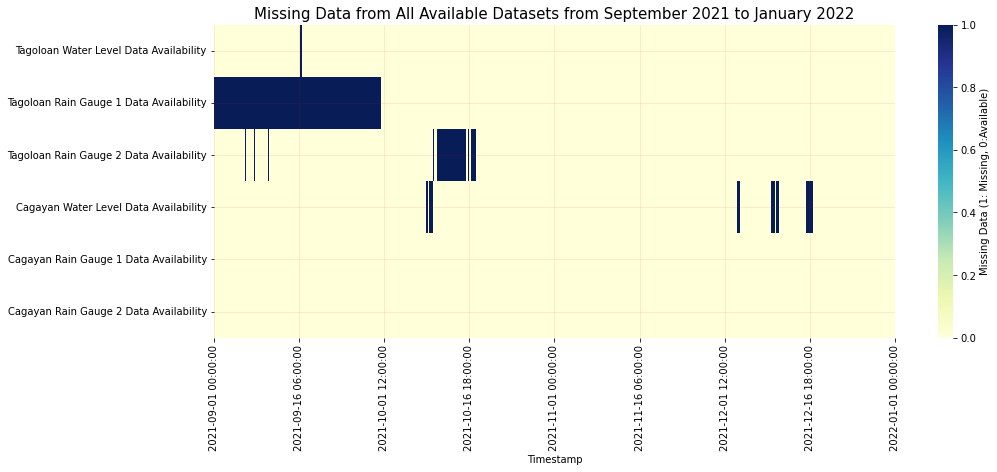

In [25]:
import numpy as np
def set_time_range():
    run = True
    while run:
        try:
            input_start_date = str(input("Please input Start Date (Format=Month,Date,Year): "))
            start_date_datetime = pd.to_datetime(input_start_date,format="%m,%d,%Y")

            input_end_date = str(input("Please input End Date (Format=Month,Date,Year): "))
            end_date_datetime = pd.to_datetime(input_end_date,format="%m,%d,%Y")

            print((f"Date start is {start_date_datetime} and End Date is {end_date_datetime + datetime.timedelta(days = 1)}"))
            date_confirm = input("Type y if the input is correct or n to try again: ")
            if date_confirm == "y":
                start_date = start_date_datetime
                end_date = end_date_datetime + datetime.timedelta(days = 1)
                run = False
            elif date_confirm == "n":
                continue
            else:
                raise ValueError
                
        except Exception as e:
            print(e)
    return start_date, end_date

while True:
    try:
        select_date = int(input('Do you want to plot a specific time range? (1: Yes, 0: No)'))
        if select_date not in [1,2]:
            raise ValueError
        start_date, end_date = set_time_range()
        break
    except Exception as e:
        print(e)
        print('Please try again')

mask = (complete_df.index >= start_date ) & (complete_df.index <= end_date)
new_df = complete_df.loc[mask]
sub_fig, sub_ax = plot_missing(new_df)

step = int(len(new_df.index)/8)
indices = [i for i,x in enumerate(new_df.index) if i%step==0]
dates = [x for i,x in enumerate(new_df.index) if i%step==0]

sub_ax.set_xticks(indices)
sub_ax.set_xticklabels(dates)

start_text = start_date.strftime("%B %Y")
end_text = end_date.strftime("%B %Y")
sub_ax.set_title(f"Missing Data from All Available Datasets from {start_text} to {end_text}", fontdict={'fontsize':15})
sub_fig.savefig(f"Missing Data Images/{start_text} to {end_text}.jpeg")
plt.show()